# Exercise 10: Convolutional neural network

In this exercise, we will look at an introduction of classifying images using deep convolutional neural networks.

Training convolutional networks on many images can be quite time consuming. We use the same small standard dataset from last weeks exercise. I tgives a good introduction to the topic and is available in Keras. 

The CIFAR-10 data set consists of 50000 training and 10000 test images of size 32x32 labelled into 10 classes. See also https://keras.io/datasets/#cifar10-small-image-classification


In [45]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

Get the datasets if you did not load them last week. Some people experienced problems with loading directly from keras, if that did not work, you can also use the function below which uses http instead of https.

In [ ]:
# the keras routines below might generate a ssl error inside jupyter notebooks
#
# (x_train, y_train_label), (x_test, y_test_label) = cifar10.load_data()
# 

# this is the same code, but using http instead of https
from tensorflow.python.keras.datasets.cifar import load_batch

def load_cifar_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = keras.utils.get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

In [2]:
(x_image_train, y_train_label), (x_image_test, y_test_label) = cifar10.load_data()
print(x_image_train.shape)
print(y_train_label.shape)

(50000, 32, 32, 3)
(50000, 1)


Let us look at some of the training images. The images contain 10 different classes.

In [3]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def show_images(images, labels):
    fig, axes = plt.subplots(3, 5)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        example = np.random.randint(len(images))
        ax.imshow(images[example])
        
        # Name of the true class.
        cls_true_name = label_names[labels[example, 0]]
        xlabel = "{0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

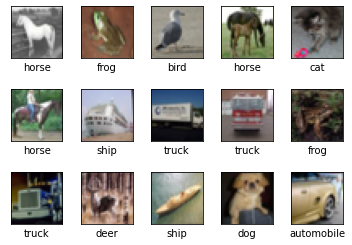

In [4]:
show_images(x_image_train, y_train_label)

In order to compute the loss function (cross entropy) the label data set must be one-hot encoded (also called categorical data)

In [5]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train_label)
y_test = keras.utils.to_categorical(y_test_label)

### Preprocessing

Any input to a neural network should be normalized. For images this could be done per image (which would also normalize contrast) or just adjust the range globally. Normalization should either be so that the data is between 0 and 1 or (even better) between -1 and 1.

In [6]:
x_train = (2.0 * x_image_train.astype(np.float32) / 255.0) - 1.0
x_test = (2.0 * x_image_test.astype(np.float32) / 255.0) - 1.0
print(np.min(x_train), np.max(x_train))

-1.0 1.0


The following code calculates a simple convolutional network. 

For image classification, we want to have some convolutional layers, some padding and probably at the end some dense (fully connected) layers.

The last layer needs softmax as activation function for the correct number of classes.

In [7]:
def build_model_1():
    model = keras.Sequential()
    
    # add input shape
    model.add(keras.layers.Layer(input_shape=(32, 32, 3)))
    
    # add convolutional and pooling layers first
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    # add a pooling layer and another  convolutional layer here
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    
    
    # add dense layers (need to flatten the input first)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
  
    # add the last layer for the number of classes and using softmax
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model
    

In [8]:
model = build_model_1()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [10]:
history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 146s 3ms/sample - loss: 2.0530 - acc: 0.2658 - val_loss: 1.8510 - val_acc: 0.3430
Epoch 2/2
50000/50000 [==============================] - 147s 3ms/sample - loss: 1.7706 - acc: 0.3698 - val_loss: 1.6580 - val_acc: 0.4120


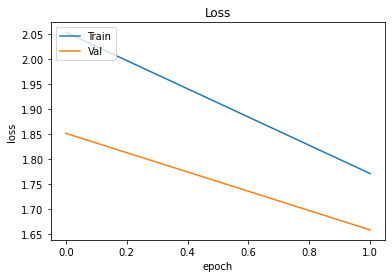

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')


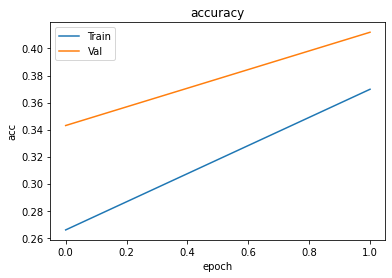

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

### Going further with the model

Even a very simple network gets some decent results. From here we can go further using deeper networks and additional features.

Try the following:
- Train for more episodes
- Make the network deeper by adding more layers
- Increase the capacity by adding more nodes per layer
- add regularization
- add dropout

Convolutional networks benefit from using GPU resources. Google provides a jupyter notebook environment with GPU support: https://colab.research.google.com

This jupyter notebook should run as it is in that environment. To actually get a GPU you have to change the runtime type in the menu 'Runtime'

When building new models, I usually like to keep the old ones for comparison, so I would recommend defining a new function for the new model.

In [54]:
def build_model_2():
     model = keras.Sequential()
     
     # add input shape
     model.add(keras.layers.Layer(input_shape=(32, 32, 3)))
    
     # add convolutional and pooling layers first
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     # add a pooling layer and another  convolutional layer here
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.MaxPooling2D((2, 2)))
     model.add(keras.layers.Dropout(0.2))
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.MaxPooling2D((2, 2)))
     model.add(keras.layers.Dropout(0.3))
    
    
     # add dense layers (need to flatten the input first)
     model.add(keras.layers.Flatten())
     #model.add(keras.layers.Dense(128, activation='relu'))
  
     # add the last layer for the number of classes and using softmax
     model.add(keras.layers.Dense(10, activation='softmax'))
    
     model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
     return model   

In [55]:
model2 = build_model_2()
model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_16 (Layer)             (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 10, 10, 32)      

In [74]:
history = model2.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 200s 4ms/sample - loss: 1.2385 - acc: 0.5612 - val_loss: 1.3058 - val_acc: 0.5385
Epoch 2/8
50000/50000 [==============================] - 176s 4ms/sample - loss: 1.0985 - acc: 0.6120 - val_loss: 1.1180 - val_acc: 0.6023
Epoch 3/8
50000/50000 [==============================] - 162s 3ms/sample - loss: 1.0042 - acc: 0.6492 - val_loss: 0.9891 - val_acc: 0.6438
Epoch 4/8
50000/50000 [==============================] - 186s 4ms/sample - loss: 0.9367 - acc: 0.6726 - val_loss: 0.9400 - val_acc: 0.6732
Epoch 5/8
50000/50000 [==============================] - 182s 4ms/sample - loss: 0.8956 - acc: 0.6881 - val_loss: 0.8787 - val_acc: 0.6960
Epoch 6/8
50000/50000 [==============================] - 190s 4ms/sample - loss: 0.8580 - acc: 0.7005 - val_loss: 0.8551 - val_acc: 0.7040
Epoch 7/8
50000/50000 [==============================] - 207s 4ms/sample - loss: 0.8267 - acc: 0.7128 - val_loss: 0.

### Optimization

Keras supports different optimization models to use in model.compile, see https://keras.io/optimizers/.

- Try different parameters for the SGD like initial learning rate and decay.
- Try some of the oder popular optimization functions, like RMSprop, AdaGrad and Adam



In [71]:
def build_model_3():
     model = keras.Sequential()
     
     # add input shape
     model.add(keras.layers.Layer(input_shape=(32, 32, 3)))
    
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.MaxPooling2D((2, 2)))
     model.add(keras.layers.Dropout(0.2))
     
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.MaxPooling2D((2, 2)))
     model.add(keras.layers.Dropout(0.3))

     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.Conv2D(32,3, padding='valid', activation='relu'))
     model.add(keras.layers.Dropout(0.4))
    
    
     # add dense layers (need to flatten the input first)
     model.add(keras.layers.Flatten())
     #model.add(keras.layers.Dense(128, activation='relu'))
  
     # add the last layer for the number of classes and using softmax
     model.add(keras.layers.Dense(10, activation='softmax'))
    
     model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
     return model  

In [72]:
model3 = build_model_3()
model3.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_23 (Layer)             (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 10, 10, 32)      

In [73]:
model3.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 171s 3ms/sample - loss: 1.8798 - acc: 0.2984 - val_loss: 1.5425 - val_acc: 0.4276
Epoch 2/2
50000/50000 [==============================] - 170s 3ms/sample - loss: 1.5851 - acc: 0.4191 - val_loss: 1.4157 - val_acc: 0.4825
